# Voice judgoor

Here we showcase a full-end-to-end flow of:
1. training a model for a specific task (judging voices)
2. creating a proof of judgment
3. creating and deploying an evm verifier
4. verifying the proof of judgment using the verifier

First we download a few voice related datasets from kaggle, which are all labelled using the same emotion and tone labelling standard.

We have 8 emotions in both speaking and singing datasets: neutral, calm, happy, sad, angry, fear, disgust, surprise.

To download the dataset make sure you have the kaggle cli installed in your local env `pip install kaggle`. Make sure you set up your `kaggle.json` file as detailed [here](https://www.kaggle.com/docs/api#getting-started-installation-&-authentication).
Then run the associated `voice_data.sh` data download script: `sh voice_data.sh`.

Make sure you set the `VOICE_DATA_DIR` variables to point to the directory the `voice_data.sh` script has downloaded to. This script also accepts an argument to download to a specific directory: `sh voice_data.sh /path/to/voice/data`.


In [ ]:
!pip install kaggle
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
!mkdir -p ~/.kaggle
!echo "{\"username\":\"joshiaseam\",\"key\":\"b1416a476daa1218570556e389b693d2\"}" > ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

{"username":"joshiaseam","key":"b1416a476daa1218570556e389b693d2"}


In [ ]:
!kaggle datasets download uwrfkaggler/ravdess-emotional-song-audio -p data/RAVDESS_SONG --unzip

100% 455M/456M [00:17<00:00, 14.9MB/s]
100% 456M/456M [00:17<00:00, 27.7MB/s]


In [ ]:
!kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio -p data/RAVDESS_SPEECH --unzip

 99% 426M/429M [00:10<00:00, 44.0MB/s]
100% 429M/429M [00:11<00:00, 40.8MB/s]


In [ ]:
!kaggle datasets download ejlok1/cremad -p data --unzip
!mv data/AudioWAV data/CREMA-D

100% 451M/451M [00:12<00:00, 40.0MB/s]
100% 451M/451M [00:12<00:00, 37.2MB/s]


In [ ]:
!kaggle datasets download ejlok1/surrey-audiovisual-expressed-emotion-savee -p data --unzip
!mv data/ALL data/SAVEE

 98% 105M/107M [00:03<00:00, 43.2MB/s]
100% 107M/107M [00:03<00:00, 34.7MB/s]


In [ ]:
!kaggle datasets download ejlok1/toronto-emotional-speech-set-tess -p data --unzip
!mv "data/TESS Toronto emotional speech set data" data/TESS
!rm -r "data/tess Toronto emotional speech set data"

 99% 424M/428M [00:10<00:00, 45.0MB/s]
100% 428M/428M [00:10<00:00, 41.3MB/s]
rm: cannot remove 'data/tess Toronto emotional speech set data': No such file or directory


In [ ]:
!rm -rf "/content/data/TESS/TESS Toronto emotional speech set data"

In [ ]:

import os
# os.environ["VOICE_DATA_DIR"] = "."

voice_data_dir = os.environ.get('VOICE_DATA_DIR')

#  if is none set to ""
if voice_data_dir is None:
    voice_data_dir = ""

print("voice_data_dir: ", voice_data_dir)


voice_data_dir:  


### TESS Dataset

In [ ]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

from torch import nn
import ezkl
import os
import json
import pandas as pd
import logging

# read in VOICE_DATA_DIR from environment variable

# FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
# logging.basicConfig(format=FORMAT)
# logging.getLogger().setLevel(logging.INFO)


Tess = os.path.join(voice_data_dir, "data/TESS/")

tess = os.listdir(Tess)

emotions = []
files = []

for item in tess:
    items = os.listdir(Tess + item)
    for file in items:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            emotions.append('surprise')
        else:
            emotions.append(part)
        files.append(Tess + item + '/' + file)

tess_df = pd.concat([pd.DataFrame(emotions, columns=['Emotions']), pd.DataFrame(files, columns=['Files'])], axis=1)
tess_df

NameError: name 'voice_data_dir' is not defined

### RAVDESS SONG dataset

In [ ]:
Ravdess = os.path.join(voice_data_dir, "data/RAVDESS_SONG/audio_song_actors_01-24/")

ravdess_list = os.listdir(Ravdess)

files = []
emotions = []

for item in ravdess_list:
    actor = os.listdir(Ravdess + item)
    for file in actor:
        name = file.split('.')[0]
        parts = name.split('-')
        emotions.append(int(parts[2]))
        files.append(Ravdess + item + '/' + file)

emotion_data = pd.DataFrame(emotions, columns=['Emotions'])
files_data = pd.DataFrame(files, columns=['Files'])

ravdess_song_df = pd.concat([emotion_data, files_data], axis=1)

ravdess_song_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

ravdess_song_df

,Emotions,Files
0,sad,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
1,angry,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
2,fear,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
3,angry,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
4,fear,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
...,...,...
1007,angry,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
1008,happy,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
1009,fear,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...
1010,sad,data/RAVDESS_SONG/audio_song_actors_01-24/Acto...


### RAVDESS SPEECH Dataset

In [ ]:
Ravdess = os.path.join(voice_data_dir, "data/RAVDESS_SPEECH/audio_speech_actors_01-24/")

ravdess_list = os.listdir(Ravdess)

files = []
emotions = []

for item in ravdess_list:
    actor = os.listdir(Ravdess + item)
    for file in actor:
        name = file.split('.')[0]
        parts = name.split('-')
        emotions.append(int(parts[2]))
        files.append(Ravdess + item + '/' + file)

emotion_data = pd.DataFrame(emotions, columns=['Emotions'])
files_data = pd.DataFrame(files, columns=['Files'])

ravdess_df = pd.concat([emotion_data, files_data], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

ravdess_df

,Emotions,Files
0,sad,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
1,angry,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
2,calm,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
3,calm,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
4,sad,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
...,...,...
1435,angry,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
1436,angry,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
1437,angry,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
1438,surprise,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...


### CREMA Dataset

In [ ]:
Crema = os.path.join(voice_data_dir, "data/CREMA-D/")

crema = os.listdir(Crema)
emotions = []
files = []

for item in crema:
    files.append(Crema + item)

    parts = item.split('_')
    if parts[2] == 'SAD':
        emotions.append('sad')
    elif parts[2] == 'ANG':
        emotions.append('angry')
    elif parts[2] == 'DIS':
        emotions.append('disgust')
    elif parts[2] == 'FEA':
        emotions.append('fear')
    elif parts[2] == 'HAP':
        emotions.append('happy')
    elif parts[2] == 'NEU':
        emotions.append('neutral')
    else :
        emotions.append('unknown')

emotions_data = pd.DataFrame(emotions, columns=['Emotions'])
files_data = pd.DataFrame(files, columns=['Files'])

crema_df = pd.concat([emotions_data, files_data], axis=1)

crema_df

,Emotions,Files
0,disgust,data/CREMA-D/1040_DFA_DIS_XX.wav
1,sad,data/CREMA-D/1088_IEO_SAD_MD.wav
2,fear,data/CREMA-D/1010_ITS_FEA_XX.wav
3,fear,data/CREMA-D/1016_TIE_FEA_XX.wav
4,happy,data/CREMA-D/1081_TIE_HAP_XX.wav
...,...,...
7437,angry,data/CREMA-D/1052_TAI_ANG_XX.wav
7438,sad,data/CREMA-D/1073_TIE_SAD_XX.wav
7439,disgust,data/CREMA-D/1082_TAI_DIS_XX.wav
7440,neutral,data/CREMA-D/1007_IOM_NEU_XX.wav


### SAVEE Dataset

In [ ]:
Savee = os.path.join(voice_data_dir,"data/SAVEE/")

savee = os.listdir(Savee)

emotions = []
files = []

for item in savee:
    files.append(Savee + item)
    part = item.split('_')[1]
    ele = part[:-6]
    if ele == 'a':
        emotions.append('angry')
    elif ele == 'd':
        emotions.append('disgust')
    elif ele == 'f':
        emotions.append('fear')
    elif ele == 'h':
        emotions.append('happy')
    elif ele == 'n':
        emotions.append('neutral')
    elif ele == 'sa':
        emotions.append('sad')
    else:
        emotions.append('surprise')

savee_df = pd.concat([pd.DataFrame(emotions, columns=['Emotions']), pd.DataFrame(files, columns=['Files'])], axis=1)
savee_df

,Emotions,Files
0,fear,data/SAVEE/DC_f06.wav
1,sad,data/SAVEE/JK_sa09.wav
2,angry,data/SAVEE/KL_a07.wav
3,neutral,data/SAVEE/JK_n12.wav
4,sad,data/SAVEE/JK_sa15.wav
...,...,...
475,surprise,data/SAVEE/JK_su14.wav
476,happy,data/SAVEE/DC_h06.wav
477,surprise,data/SAVEE/JK_su04.wav
478,neutral,data/SAVEE/JK_n20.wav


### Combining all datasets

In [ ]:
df = pd.concat([ravdess_df, ravdess_song_df, crema_df, tess_df, savee_df], axis = 0)
# relabel indices
df.index = range(len(df.index))
df.to_csv("df.csv",index=False)
df


,Emotions,Files
0,sad,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
1,angry,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
2,calm,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
3,calm,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
4,sad,data/RAVDESS_SPEECH/audio_speech_actors_01-24/...
...,...,...
13169,surprise,data/SAVEE/JK_su14.wav
13170,happy,data/SAVEE/DC_h06.wav
13171,surprise,data/SAVEE/JK_su04.wav
13172,neutral,data/SAVEE/JK_n20.wav


<Axes: xlabel='Emotions', ylabel='Count'>

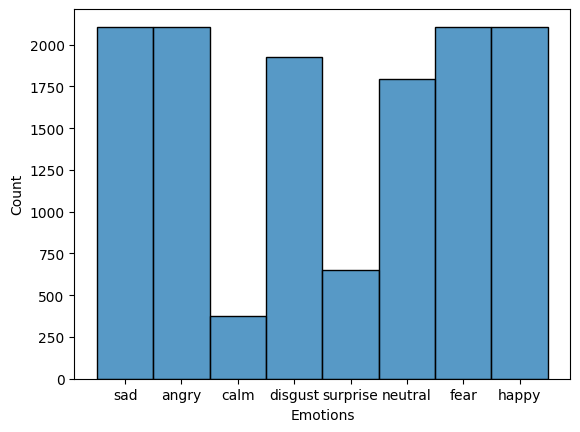

In [ ]:
import seaborn as sns
sns.histplot(data=df, x="Emotions")


### Training

Here we convert all audio files into 2D frequency-domain spectrograms so that we can leverage convolutional neural networks, which tend to be more efficient than time-series model like RNNs or LSTMs.
We thus:
1. Extract the mel spectrogram from each of the audio recordings.
2. Rescale each of these to the decibel (DB) scale.
3. Define the model as the following model: `(x) -> (conv) -> (relu) -> (linear) -> (y)`


You may notice that we introduce a second computational graph `(key) -> (key)`. The reasons for this are to do with MEV, and if you are not interested you can skip the following paragraph.

Let's say that obtaining a high score from the judge and then submitting said score to the EVM verifier could result in the issuance of a reward (financial or otherwise). There is an incentive then for MEV bots to scalp any issued valid proof and submit a duplicate transaction with the same proof to the verifier contract in the hopes of obtaining the reward before the original issuer. Here we add `(key) -> (key)` such that the transaction creator's public key / address is both a private input AND a public input to the proof. As such the on-chain verification only succeeds if the key passed in during proof time is also passed in as a public input to the contract. The reward issued by the contract can then be irrevocably tied to that key such that even if the proof is submitted by another actor, the reward would STILL go to the original singer / transaction issuer.

In [ ]:


import librosa
import numpy as np
import matplotlib.pyplot as plt


#stft extraction from augmented data
def extract_mel_spec(filename):
    x,sr=librosa.load(filename,duration=3,offset=0)
    X = librosa.feature.melspectrogram(y=x, sr=sr)
    Xdb = librosa.power_to_db(X, ref=np.max)
    Xdb = Xdb.reshape(1,128,-1)
    return Xdb


df = pd.read_csv("df.csv")
Xdb=df.iloc[:,1].apply(lambda x: extract_mel_spec(x))


Here we convert label to a number between 0 and 1 where 1 is pleasant surprised and 0 is disgust and the rest are floats in between. The model loves pleasantly surprised voices and hates disgust ;)

In [ ]:
# get max size
max_size = 0
for i in range(len(Xdb)):
    if Xdb[i].shape[2] > max_size:
        max_size = Xdb[i].shape[2]

# 0 pad 2nd dim to max size
Xdb=Xdb.apply(lambda x: np.pad(x,((0,0),(0,0),(0,max_size-x.shape[2]))))

Xdb=pd.DataFrame(Xdb)
Xdb['label'] = df['Emotions']
# convert label to a number between 0 and 1 where 1 is pleasant surprised and 0 is disgust and the rest are floats in betwee
Xdb['label'] = Xdb['label'].apply(lambda x: 5 if x=='surprise' else 1 if x=='disgust' else 2 if x=='fear' else 3 if x=='happy' else 4 if x=='sad' else 0)

Xdb.iloc[0,0][0].shape

(128, 130)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class EnhancedVoiceModel(nn.Module):
    def __init__(self, input_size=(128, 130)):
        super(EnhancedVoiceModel, self).__init__()

        self.conv1 = DepthwiseSeparableConv(in_channels=1, out_channels=16, kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.AdaptiveMaxPool2d((128, 128))

        self.conv2 = DepthwiseSeparableConv(in_channels=16, out_channels=4, kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(4)
        self.pool2 = nn.AdaptiveMaxPool2d((8, 8))

        self.fc1 = nn.Linear(256, 64)  # This needs dynamic adjustment based on input size
        self.fc2 = nn.Linear(64, 6)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

        self.export = False

    def set_export(self, export):
        self.export = export

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool2(out)
        out = self.dropout(out)

        out = out.view(out.size(0), -1)  # Flatten the tensor for the linear layer
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        predicted_indices = torch.argmax(self.sigmoid(out), dim=1)

        if self.export:
            return predicted_indices
        else:
            return out, predicted_indices

circuit = EnhancedVoiceModel()

print(Xdb.iloc[0,0][0].shape)


output = circuit(torch.tensor(Xdb.iloc[0,0][0].reshape(1,1,128,130)))

output





(128, 130)


(tensor([[-0.5397, -0.4584,  1.1821,  0.3512,  0.6237, -0.2858]],
        grad_fn=<AddmmBackward0>),
 tensor([2]))

Here we leverage the classic Adam optimizer, coupled with 0.001 weight decay so as to regularize the model. The weight decay (a.k.a L2 regularization) can also help on the zk-circuit end of things in that it prevents inputs to Halo2 lookup tables from falling out of range (lookup tables are how we represent non-linearities like ReLU and Sigmoid inside our circuits).

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model using pytorch
n_epochs = 200    # number of epochs to run
batch_size = 256  # size of each batch


# Convert DataFrame to tensors
features = torch.Tensor(np.stack(Xdb.iloc[:, 0].values)).to(device)
labels = torch.Tensor(Xdb.iloc[:, 1].values.astype(np.float32)).view(-1, 1).to(device)

# Create TensorDataset and DataLoader
dataset = TensorDataset(features, labels)
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


circuit.to(device)


loss_fn = nn.CrossEntropyLoss()  # crossentropy loss
# adds l2 regularization
optimizer = torch.optim.Adam(circuit.parameters(), lr=0.001, weight_decay=0.001)

# # randomly shuffle dataset
# Xdb = Xdb.sample(frac=1).reset_index(drop=True)

# # split into train and test and validation sets with 80% train, 10% test, 10% validation
# train = Xdb.iloc[:int(len(Xdb)*0.8)]
# test = Xdb.iloc[int(len(Xdb)*0.8):int(len(Xdb)*0.9)]
# val = Xdb.iloc[int(len(Xdb)*0.9):]

# batches_per_epoch = len(train)


for epoch in range(n_epochs):
    circuit.train()
    with tqdm(train_loader, unit="batch") as tepoch:
        for data, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            # Move data to the correct device
            data, labels = data.to(device), labels.to(device)

            one_hot_labels = F.one_hot(labels.to(torch.int64), num_classes=6).squeeze().float()

            # Forward pass
            outputs, predicted_indices = circuit(data)

            loss = loss_fn(outputs, one_hot_labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

    circuit.eval()  # Set model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():  # Inference mode, gradients not needed
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            one_hot_labels = F.one_hot(labels.to(torch.int64), num_classes=6).squeeze().float()
            outputs, predicted_indices = circuit(data)
            loss = loss_fn(outputs, one_hot_labels)
            total_loss += loss.item() * data.size(0)  # Multiply by batch size

            total_samples += labels.size(0)
            correct_predictions += (predicted_indices == labels).sum().item()

    avg_loss = total_loss / len(val_loader.dataset)
    accuracy = correct_predictions / total_samples
    print(f"Validation loss: {avg_loss}, Accuracy: {accuracy}")



circuit.eval()  # Set model to evaluation mode
total_loss = 0
with torch.no_grad():  # Inference mode, gradients not needed
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        one_hot_labels = F.one_hot(labels.to(torch.int64), num_classes=6).squeeze().float()
        outputs, predicted_indices = circuit(data)
        loss = loss_fn(outputs, one_hot_labels)
        total_loss += loss.item() * data.size(0)  # Multiply by batch size

        total_samples += labels.size(0)
        correct_predictions += (predicted_indices == labels).sum().item()


avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / total_samples

print(f"Testing loss: {avg_loss}, Accuracy: {accuracy}")


Epoch 0: 100%|██████████| 42/42 [00:02<00:00, 19.78batch/s, loss=1.57]


Validation loss: 1.7015695921025253, Accuracy: 71.69044006069802


Epoch 1: 100%|██████████| 42/42 [00:00<00:00, 95.89batch/s, loss=1.55]


Validation loss: 1.644200314158554, Accuracy: 67.11456752655539


Epoch 2: 100%|██████████| 42/42 [00:00<00:00, 92.13batch/s, loss=1.72]


Validation loss: 1.5980232489127129, Accuracy: 65.24203338391503


Epoch 3: 100%|██████████| 42/42 [00:00<00:00, 94.16batch/s, loss=1.51]


Validation loss: 1.561911997737219, Accuracy: 66.07435508345979


Epoch 4: 100%|██████████| 42/42 [00:00<00:00, 91.12batch/s, loss=1.49]


Validation loss: 1.5426108041193127, Accuracy: 64.54476479514416


Epoch 5: 100%|██████████| 42/42 [00:00<00:00, 95.74batch/s, loss=1.44]


Validation loss: 1.51475424126175, Accuracy: 62.6464339908953


Epoch 6: 100%|██████████| 42/42 [00:00<00:00, 95.47batch/s, loss=1.46]


Validation loss: 1.5046142544116887, Accuracy: 58.965098634294385


Epoch 7: 100%|██████████| 42/42 [00:00<00:00, 97.69batch/s, loss=1.59]


Validation loss: 1.4895968590954909, Accuracy: 56.813353566009106


Epoch 8: 100%|██████████| 42/42 [00:00<00:00, 95.97batch/s, loss=1.33]


Validation loss: 1.4713291069082859, Accuracy: 62.56752655538695


Epoch 9: 100%|██████████| 42/42 [00:00<00:00, 96.83batch/s, loss=1.52]


Validation loss: 1.4714885146918173, Accuracy: 60.29514415781487


Epoch 10: 100%|██████████| 42/42 [00:00<00:00, 94.35batch/s, loss=1.48]


Validation loss: 1.4594388697324645, Accuracy: 59.96661608497724


Epoch 11: 100%|██████████| 42/42 [00:00<00:00, 90.10batch/s, loss=1.68]


Validation loss: 1.4500590611661874, Accuracy: 60.09104704097117


Epoch 12: 100%|██████████| 42/42 [00:00<00:00, 94.64batch/s, loss=1.58]


Validation loss: 1.4274076773291835, Accuracy: 60.167678300455236


Epoch 13: 100%|██████████| 42/42 [00:00<00:00, 97.86batch/s, loss=1.55]


Validation loss: 1.430142078848276, Accuracy: 57.45675265553869


Epoch 14: 100%|██████████| 42/42 [00:00<00:00, 93.48batch/s, loss=1.44]


Validation loss: 1.4215852501540698, Accuracy: 59.81790591805766


Epoch 15: 100%|██████████| 42/42 [00:00<00:00, 95.10batch/s, loss=1.3]


Validation loss: 1.411498640484441, Accuracy: 59.965098634294385


Epoch 16: 100%|██████████| 42/42 [00:00<00:00, 94.57batch/s, loss=1.42]


Validation loss: 1.4082360220606664, Accuracy: 59.09711684370258


Epoch 17: 100%|██████████| 42/42 [00:00<00:00, 94.55batch/s, loss=1.5]


Validation loss: 1.4113790713962908, Accuracy: 58.36722306525038


Epoch 18: 100%|██████████| 42/42 [00:00<00:00, 94.22batch/s, loss=1.43]


Validation loss: 1.4022264932826365, Accuracy: 56.25113808801214


Epoch 19: 100%|██████████| 42/42 [00:00<00:00, 95.35batch/s, loss=1.38]


Validation loss: 1.4468166462749197, Accuracy: 55.504552352048556


Epoch 20: 100%|██████████| 42/42 [00:00<00:00, 94.10batch/s, loss=1.43]


Validation loss: 1.353387644330721, Accuracy: 62.70257966616085


Epoch 21: 100%|██████████| 42/42 [00:00<00:00, 91.15batch/s, loss=1.45]


Validation loss: 1.3812562730135072, Accuracy: 57.61608497723824


Epoch 22: 100%|██████████| 42/42 [00:00<00:00, 90.61batch/s, loss=1.6]


Validation loss: 1.4164987305046395, Accuracy: 56.53034901365706


Epoch 23: 100%|██████████| 42/42 [00:00<00:00, 94.98batch/s, loss=1.35]


Validation loss: 1.3769688135937241, Accuracy: 58.91198786039454


Epoch 24: 100%|██████████| 42/42 [00:00<00:00, 93.95batch/s, loss=1.37]


Validation loss: 1.3953943587217779, Accuracy: 57.86418816388468


Epoch 25: 100%|██████████| 42/42 [00:00<00:00, 93.34batch/s, loss=1.49]


Validation loss: 1.3440970916849349, Accuracy: 60.69423368740516


Epoch 26: 100%|██████████| 42/42 [00:00<00:00, 96.14batch/s, loss=1.38]


Validation loss: 1.3544477021748451, Accuracy: 59.05083459787557


Epoch 27: 100%|██████████| 42/42 [00:00<00:00, 97.09batch/s, loss=1.31]


Validation loss: 1.3541493882539601, Accuracy: 57.17298937784522


Epoch 28: 100%|██████████| 42/42 [00:00<00:00, 94.05batch/s, loss=1.35]


Validation loss: 1.3517981490886266, Accuracy: 57.54248861911988


Epoch 29: 100%|██████████| 42/42 [00:00<00:00, 95.06batch/s, loss=1.36]


Validation loss: 1.3245017763696418, Accuracy: 60.02200303490137


Epoch 30: 100%|██████████| 42/42 [00:00<00:00, 91.50batch/s, loss=1.4]


Validation loss: 1.3589531429258934, Accuracy: 57.53869499241274


Epoch 31: 100%|██████████| 42/42 [00:00<00:00, 95.80batch/s, loss=1.48]


Validation loss: 1.3304463939710163, Accuracy: 60.27314112291351


Epoch 32: 100%|██████████| 42/42 [00:00<00:00, 94.57batch/s, loss=1.5]


Validation loss: 1.3498434494044604, Accuracy: 58.8391502276176


Epoch 33: 100%|██████████| 42/42 [00:00<00:00, 94.21batch/s, loss=1.35]


Validation loss: 1.3431706278385631, Accuracy: 57.90288315629742


Epoch 34: 100%|██████████| 42/42 [00:00<00:00, 94.32batch/s, loss=1.27]


Validation loss: 1.3293638164248198, Accuracy: 58.54855842185129


Epoch 35: 100%|██████████| 42/42 [00:00<00:00, 94.43batch/s, loss=1.3]


Validation loss: 1.30689814239062, Accuracy: 55.749620637329286


Epoch 36: 100%|██████████| 42/42 [00:00<00:00, 98.44batch/s, loss=1.25]


Validation loss: 1.3330362787376948, Accuracy: 56.6896813353566


Epoch 37: 100%|██████████| 42/42 [00:00<00:00, 92.65batch/s, loss=1.31]


Validation loss: 1.300082667463647, Accuracy: 59.05993930197268


Epoch 38: 100%|██████████| 42/42 [00:00<00:00, 94.05batch/s, loss=1.24]


Validation loss: 1.3076608797849039, Accuracy: 58.656297420333836


Epoch 39: 100%|██████████| 42/42 [00:00<00:00, 94.69batch/s, loss=1.25]


Validation loss: 1.311373288606114, Accuracy: 58.066009104704094


Epoch 40: 100%|██████████| 42/42 [00:00<00:00, 93.84batch/s, loss=1.49]


Validation loss: 1.2992949270514689, Accuracy: 59.03869499241274


Epoch 41: 100%|██████████| 42/42 [00:00<00:00, 93.11batch/s, loss=1.36]


Validation loss: 1.2974700643730452, Accuracy: 58.5690440060698


Epoch 42: 100%|██████████| 42/42 [00:00<00:00, 92.95batch/s, loss=1.37]


Validation loss: 1.3234574427554024, Accuracy: 57.77845220030349


Epoch 43: 100%|██████████| 42/42 [00:00<00:00, 97.71batch/s, loss=1.41]


Validation loss: 1.3462408531417616, Accuracy: 55.591805766312596


Epoch 44: 100%|██████████| 42/42 [00:00<00:00, 92.69batch/s, loss=1.36]


Validation loss: 1.3931947286284567, Accuracy: 61.14567526555387


Epoch 45: 100%|██████████| 42/42 [00:00<00:00, 88.88batch/s, loss=1.24]


Validation loss: 1.292695746074497, Accuracy: 60.14871016691958


Epoch 46: 100%|██████████| 42/42 [00:00<00:00, 91.80batch/s, loss=1.39]


Validation loss: 1.3222478335109937, Accuracy: 58.18437025796661


Epoch 47: 100%|██████████| 42/42 [00:00<00:00, 95.17batch/s, loss=1.31]


Validation loss: 1.2849948136687097, Accuracy: 56.90895295902883


Epoch 48: 100%|██████████| 42/42 [00:00<00:00, 94.41batch/s, loss=1.27]


Validation loss: 1.277868792030265, Accuracy: 60.192716236722305


Epoch 49: 100%|██████████| 42/42 [00:00<00:00, 94.85batch/s, loss=1.41]


Validation loss: 1.2852798041877689, Accuracy: 59.43854324734446


Epoch 50: 100%|██████████| 42/42 [00:00<00:00, 94.16batch/s, loss=1.45]


Validation loss: 1.2800490273691272, Accuracy: 60.36267071320182


Epoch 51: 100%|██████████| 42/42 [00:00<00:00, 94.36batch/s, loss=1.32]


Validation loss: 1.377485006459747, Accuracy: 61.874051593323216


Epoch 52: 100%|██████████| 42/42 [00:00<00:00, 92.70batch/s, loss=1.17]


Validation loss: 1.268672335672451, Accuracy: 60.66995447647952


Epoch 53: 100%|██████████| 42/42 [00:00<00:00, 94.98batch/s, loss=1.41]


Validation loss: 1.2947100335802764, Accuracy: 57.34825493171472


Epoch 54: 100%|██████████| 42/42 [00:00<00:00, 92.33batch/s, loss=1.27]


Validation loss: 1.2895564441434892, Accuracy: 60.35811836115326


Epoch 55: 100%|██████████| 42/42 [00:00<00:00, 92.34batch/s, loss=1.4]


Validation loss: 1.2855463704498475, Accuracy: 59.43323216995448


Epoch 56: 100%|██████████| 42/42 [00:00<00:00, 94.28batch/s, loss=1.42]


Validation loss: 1.261364464152022, Accuracy: 59.201062215478


Epoch 57: 100%|██████████| 42/42 [00:00<00:00, 96.02batch/s, loss=1.3]


Validation loss: 1.2701876671795418, Accuracy: 56.40364188163885


Epoch 58: 100%|██████████| 42/42 [00:00<00:00, 94.10batch/s, loss=1.41]


Validation loss: 1.293720020148027, Accuracy: 57.986342943854325


Epoch 59: 100%|██████████| 42/42 [00:00<00:00, 94.32batch/s, loss=1.36]


Validation loss: 1.326120755922089, Accuracy: 61.653262518968134


Epoch 60: 100%|██████████| 42/42 [00:00<00:00, 93.43batch/s, loss=1.24]


Validation loss: 1.2608866789272233, Accuracy: 57.79362670713202


Epoch 61: 100%|██████████| 42/42 [00:00<00:00, 92.97batch/s, loss=1.19]


Validation loss: 1.2758543612562652, Accuracy: 57.965098634294385


Epoch 62: 100%|██████████| 42/42 [00:00<00:00, 94.69batch/s, loss=1.16]


Validation loss: 1.2672414763382607, Accuracy: 59.8247344461305


Epoch 63: 100%|██████████| 42/42 [00:00<00:00, 94.05batch/s, loss=1.34]


Validation loss: 1.3092924443289795, Accuracy: 58.404400606980275


Epoch 64: 100%|██████████| 42/42 [00:00<00:00, 95.01batch/s, loss=1.22]


Validation loss: 1.2902368178678754, Accuracy: 62.53945371775417


Epoch 65: 100%|██████████| 42/42 [00:00<00:00, 94.60batch/s, loss=1.23]


Validation loss: 1.2577106580025148, Accuracy: 58.167678300455236


Epoch 66: 100%|██████████| 42/42 [00:00<00:00, 94.32batch/s, loss=1.18]


Validation loss: 1.2431909985535061, Accuracy: 61.36722306525038


Epoch 67: 100%|██████████| 42/42 [00:00<00:00, 94.61batch/s, loss=1.08]


Validation loss: 1.2473018328589989, Accuracy: 59.80955993930197


Epoch 68: 100%|██████████| 42/42 [00:00<00:00, 92.81batch/s, loss=1.24]


Validation loss: 1.2515394535701445, Accuracy: 60.051593323217


Epoch 69: 100%|██████████| 42/42 [00:00<00:00, 91.55batch/s, loss=1.18]


Validation loss: 1.262804357524345, Accuracy: 57.19575113808801


Epoch 70: 100%|██████████| 42/42 [00:00<00:00, 89.73batch/s, loss=1.45]


Validation loss: 1.2388231962331329, Accuracy: 57.071320182094084


Epoch 71: 100%|██████████| 42/42 [00:00<00:00, 94.81batch/s, loss=1.39]


Validation loss: 1.2403817735781981, Accuracy: 60.80804248861912


Epoch 72: 100%|██████████| 42/42 [00:00<00:00, 94.65batch/s, loss=1.2]


Validation loss: 1.2436027175920685, Accuracy: 58.02731411229135


Epoch 73: 100%|██████████| 42/42 [00:00<00:00, 98.12batch/s, loss=1.18]


Validation loss: 1.2550337531678775, Accuracy: 58.42488619119879


Epoch 74: 100%|██████████| 42/42 [00:00<00:00, 91.85batch/s, loss=1.35]


Validation loss: 1.2421115036256758, Accuracy: 60.50682852807284


Epoch 75: 100%|██████████| 42/42 [00:00<00:00, 87.56batch/s, loss=1.19]


Validation loss: 1.2406583233921589, Accuracy: 61.35735963581184


Epoch 76: 100%|██████████| 42/42 [00:00<00:00, 95.03batch/s, loss=1.39]


Validation loss: 1.240710238766417, Accuracy: 59.63657056145675


Epoch 77: 100%|██████████| 42/42 [00:00<00:00, 93.06batch/s, loss=1.38]


Validation loss: 1.2348994723943731, Accuracy: 58.752655538694995


Epoch 78: 100%|██████████| 42/42 [00:00<00:00, 94.27batch/s, loss=1.25]


Validation loss: 1.2268219851579218, Accuracy: 61.15250379362671


Epoch 79: 100%|██████████| 42/42 [00:00<00:00, 94.42batch/s, loss=1.19]


Validation loss: 1.2361058468883785, Accuracy: 58.51593323216996


Epoch 80: 100%|██████████| 42/42 [00:00<00:00, 95.23batch/s, loss=1.15]


Validation loss: 1.2511148695157042, Accuracy: 61.17981790591806


Epoch 81: 100%|██████████| 42/42 [00:00<00:00, 94.21batch/s, loss=1.5]


Validation loss: 1.2500868775233152, Accuracy: 58.34218512898331


Epoch 82: 100%|██████████| 42/42 [00:00<00:00, 93.26batch/s, loss=1.2]


Validation loss: 1.2260602164521746, Accuracy: 59.86342943854325


Epoch 83: 100%|██████████| 42/42 [00:00<00:00, 96.53batch/s, loss=1.51]


Validation loss: 1.2267890153777798, Accuracy: 59.47875569044006


Epoch 84: 100%|██████████| 42/42 [00:00<00:00, 95.09batch/s, loss=1.28]


Validation loss: 1.2233561393161825, Accuracy: 61.4597875569044


Epoch 85: 100%|██████████| 42/42 [00:00<00:00, 94.08batch/s, loss=1.27]


Validation loss: 1.2335719121605926, Accuracy: 60.69802731411229


Epoch 86: 100%|██████████| 42/42 [00:00<00:00, 92.88batch/s, loss=1.21]


Validation loss: 1.2193335893483372, Accuracy: 59.401365705614566


Epoch 87: 100%|██████████| 42/42 [00:00<00:00, 90.31batch/s, loss=1.34]


Validation loss: 1.2380167283852654, Accuracy: 61.24203338391502


Epoch 88: 100%|██████████| 42/42 [00:00<00:00, 91.84batch/s, loss=1.21]


Validation loss: 1.227507234343267, Accuracy: 59.00910470409712


Epoch 89: 100%|██████████| 42/42 [00:00<00:00, 95.46batch/s, loss=1.45]


Validation loss: 1.2147471313230547, Accuracy: 61.846737481031866


Epoch 90: 100%|██████████| 42/42 [00:00<00:00, 94.13batch/s, loss=1.21]


Validation loss: 1.2273664980991115, Accuracy: 59.43626707132018


Epoch 91: 100%|██████████| 42/42 [00:00<00:00, 89.69batch/s, loss=1.33]


Validation loss: 1.221205787521212, Accuracy: 60.84294385432474


Epoch 92: 100%|██████████| 42/42 [00:00<00:00, 91.45batch/s, loss=1.39]


Validation loss: 1.2188485562349125, Accuracy: 60.44916540212443


Epoch 93: 100%|██████████| 42/42 [00:00<00:00, 90.48batch/s, loss=1.38]


Validation loss: 1.2257323708266517, Accuracy: 60.591805766312596


Epoch 94: 100%|██████████| 42/42 [00:00<00:00, 94.13batch/s, loss=1.35]


Validation loss: 1.219840037985528, Accuracy: 60.98482549317147


Epoch 95: 100%|██████████| 42/42 [00:00<00:00, 94.97batch/s, loss=1.33]


Validation loss: 1.2135661541963383, Accuracy: 60.33080424886191


Epoch 96: 100%|██████████| 42/42 [00:00<00:00, 94.78batch/s, loss=1.38]


Validation loss: 1.2268250656055573, Accuracy: 58.71168437025797


Epoch 97: 100%|██████████| 42/42 [00:00<00:00, 96.46batch/s, loss=1.29]


Validation loss: 1.2217586747793219, Accuracy: 60.21851289833081


Epoch 98: 100%|██████████| 42/42 [00:00<00:00, 94.12batch/s, loss=1.33]


Validation loss: 1.228111580398629, Accuracy: 59.692716236722305


Epoch 99: 100%|██████████| 42/42 [00:00<00:00, 93.20batch/s, loss=1.28]


Validation loss: 1.2142317197391586, Accuracy: 59.65857359635812


Epoch 100: 100%|██████████| 42/42 [00:00<00:00, 91.27batch/s, loss=1.37]


Validation loss: 1.2184985118136602, Accuracy: 60.36646433990895


Epoch 101: 100%|██████████| 42/42 [00:00<00:00, 94.53batch/s, loss=1.25]


Validation loss: 1.2251393035257714, Accuracy: 58.05993930197268


Epoch 102: 100%|██████████| 42/42 [00:00<00:00, 95.94batch/s, loss=1.31]


Validation loss: 1.2118427485725043, Accuracy: 60.29438543247345


Epoch 103: 100%|██████████| 42/42 [00:00<00:00, 95.27batch/s, loss=1.26]


Validation loss: 1.214336779844779, Accuracy: 60.295902883156295


Epoch 104: 100%|██████████| 42/42 [00:00<00:00, 96.67batch/s, loss=1.43]


Validation loss: 1.2284919973208437, Accuracy: 59.12443095599393


Epoch 105: 100%|██████████| 42/42 [00:00<00:00, 95.28batch/s, loss=1.33]


Validation loss: 1.2107506549050848, Accuracy: 60.43702579666161


Epoch 106: 100%|██████████| 42/42 [00:00<00:00, 96.74batch/s, loss=1.36]


Validation loss: 1.2173252073151932, Accuracy: 61.26934749620637


Epoch 107: 100%|██████████| 42/42 [00:00<00:00, 95.56batch/s, loss=1.49]


Validation loss: 1.2023002079296545, Accuracy: 59.76783004552352


Epoch 108: 100%|██████████| 42/42 [00:00<00:00, 92.34batch/s, loss=1.07]


Validation loss: 1.2079080840705558, Accuracy: 60.722306525037936


Epoch 109: 100%|██████████| 42/42 [00:00<00:00, 93.99batch/s, loss=1.23]


Validation loss: 1.2047409081495224, Accuracy: 59.36267071320182


Epoch 110: 100%|██████████| 42/42 [00:00<00:00, 95.91batch/s, loss=1.36]


Validation loss: 1.2148752185390281, Accuracy: 60.3763277693475


Epoch 111: 100%|██████████| 42/42 [00:00<00:00, 96.17batch/s, loss=1.34]


Validation loss: 1.223271396525532, Accuracy: 59.795902883156295


Epoch 112: 100%|██████████| 42/42 [00:00<00:00, 91.54batch/s, loss=1.37]


Validation loss: 1.2005021517844772, Accuracy: 61.58421851289833


Epoch 113: 100%|██████████| 42/42 [00:00<00:00, 94.39batch/s, loss=1.48]


Validation loss: 1.2020668726589683, Accuracy: 61.2845220030349


Epoch 114: 100%|██████████| 42/42 [00:00<00:00, 95.22batch/s, loss=1.27]


Validation loss: 1.2202508460408097, Accuracy: 61.61229135053111


Epoch 115: 100%|██████████| 42/42 [00:00<00:00, 95.06batch/s, loss=1.33]


Validation loss: 1.205234830043023, Accuracy: 60.380121396054626


Epoch 116: 100%|██████████| 42/42 [00:00<00:00, 94.89batch/s, loss=1.3]


Validation loss: 1.2034426120778317, Accuracy: 60.34825493171472


Epoch 117: 100%|██████████| 42/42 [00:00<00:00, 91.60batch/s, loss=1.28]


Validation loss: 1.2351359251960095, Accuracy: 59.579666160849776


Epoch 118: 100%|██████████| 42/42 [00:00<00:00, 94.47batch/s, loss=1.05]


Validation loss: 1.2037728095090805, Accuracy: 61.6350531107739


Epoch 119: 100%|██████████| 42/42 [00:00<00:00, 93.04batch/s, loss=1.1]


Validation loss: 1.2034546086205697, Accuracy: 61.694992412746586


Epoch 120: 100%|██████████| 42/42 [00:00<00:00, 94.55batch/s, loss=1.45]


Validation loss: 1.2096851859722224, Accuracy: 60.58497723823976


Epoch 121: 100%|██████████| 42/42 [00:00<00:00, 90.68batch/s, loss=1.33]


Validation loss: 1.204944344681203, Accuracy: 61.06980273141123


Epoch 122: 100%|██████████| 42/42 [00:00<00:00, 92.32batch/s, loss=1.57]


Validation loss: 1.1988693725357287, Accuracy: 60.33535660091047


Epoch 123: 100%|██████████| 42/42 [00:00<00:00, 92.68batch/s, loss=1.46]


Validation loss: 1.208853581063845, Accuracy: 59.89605462822458


Epoch 124: 100%|██████████| 42/42 [00:00<00:00, 93.90batch/s, loss=1.39]


Validation loss: 1.20684894824426, Accuracy: 61.07663125948407


Epoch 125: 100%|██████████| 42/42 [00:00<00:00, 94.63batch/s, loss=1.5]


Validation loss: 1.2030778217026243, Accuracy: 61.323216995447645


Epoch 126: 100%|██████████| 42/42 [00:00<00:00, 89.99batch/s, loss=1.32]


Validation loss: 1.207202221989089, Accuracy: 60.26631259484067


Epoch 127: 100%|██████████| 42/42 [00:00<00:00, 94.50batch/s, loss=1.35]


Validation loss: 1.2249236342035041, Accuracy: 59.128983308042486


Epoch 128: 100%|██████████| 42/42 [00:00<00:00, 93.35batch/s, loss=1.07]


Validation loss: 1.1955323257287103, Accuracy: 61.13884673748103


Epoch 129: 100%|██████████| 42/42 [00:00<00:00, 96.02batch/s, loss=1.16]


Validation loss: 1.196539427333247, Accuracy: 59.737481031866466


Epoch 130: 100%|██████████| 42/42 [00:00<00:00, 93.21batch/s, loss=1.16]


Validation loss: 1.201156789507598, Accuracy: 62.16464339908953


Epoch 131: 100%|██████████| 42/42 [00:00<00:00, 96.20batch/s, loss=1.05]


Validation loss: 1.207841523319528, Accuracy: 59.86646433990895


Epoch 132: 100%|██████████| 42/42 [00:00<00:00, 93.55batch/s, loss=1.08]


Validation loss: 1.2020944961105022, Accuracy: 60.89984825493171


Epoch 133: 100%|██████████| 42/42 [00:00<00:00, 94.51batch/s, loss=1.35]


Validation loss: 1.1967706539200362, Accuracy: 60.26783004552352


Epoch 134: 100%|██████████| 42/42 [00:00<00:00, 94.46batch/s, loss=1.35]


Validation loss: 1.1988351393903696, Accuracy: 59.69044006069803


Epoch 135: 100%|██████████| 42/42 [00:00<00:00, 91.67batch/s, loss=1.23]


Validation loss: 1.1979946191104662, Accuracy: 61.04476479514416


Epoch 136: 100%|██████████| 42/42 [00:00<00:00, 89.38batch/s, loss=1.27]


Validation loss: 1.207155769981998, Accuracy: 59.764795144157816


Epoch 137: 100%|██████████| 42/42 [00:00<00:00, 89.78batch/s, loss=1.25]


Validation loss: 1.2074450042794074, Accuracy: 60.50531107738998


Epoch 138: 100%|██████████| 42/42 [00:00<00:00, 91.83batch/s, loss=1.18]


Validation loss: 1.2110689100618608, Accuracy: 59.729135053110774


Epoch 139: 100%|██████████| 42/42 [00:00<00:00, 86.67batch/s, loss=1.34]


Validation loss: 1.1950207670107598, Accuracy: 60.99393019726859


Epoch 140: 100%|██████████| 42/42 [00:00<00:00, 87.56batch/s, loss=1.32]


Validation loss: 1.1990834253872653, Accuracy: 60.507587253414265


Epoch 141: 100%|██████████| 42/42 [00:00<00:00, 90.27batch/s, loss=1.33]


Validation loss: 1.2022935354655357, Accuracy: 59.977238239757206


Epoch 142: 100%|██████████| 42/42 [00:00<00:00, 94.19batch/s, loss=1.51]


Validation loss: 1.1944831025437628, Accuracy: 62.448406676783


Epoch 143: 100%|██████████| 42/42 [00:00<00:00, 93.27batch/s, loss=1.35]


Validation loss: 1.1996234411173055, Accuracy: 61.15098634294385


Epoch 144: 100%|██████████| 42/42 [00:00<00:00, 91.87batch/s, loss=1.51]


Validation loss: 1.199066097349245, Accuracy: 60.377086494688925


Epoch 145: 100%|██████████| 42/42 [00:00<00:00, 93.50batch/s, loss=1.3]


Validation loss: 1.201451145462997, Accuracy: 60.02959028831563


Epoch 146: 100%|██████████| 42/42 [00:00<00:00, 94.28batch/s, loss=1.35]


Validation loss: 1.1924234429693727, Accuracy: 61.66009104704097


Epoch 147: 100%|██████████| 42/42 [00:00<00:00, 93.76batch/s, loss=0.987]


Validation loss: 1.2220098471243572, Accuracy: 59.01593323216996


Epoch 148: 100%|██████████| 42/42 [00:00<00:00, 91.68batch/s, loss=1.39]


Validation loss: 1.1942844061641664, Accuracy: 63.074355083459785


Epoch 149: 100%|██████████| 42/42 [00:00<00:00, 92.89batch/s, loss=1.49]


Validation loss: 1.1900059713760167, Accuracy: 60.55235204855842


Epoch 150: 100%|██████████| 42/42 [00:00<00:00, 95.13batch/s, loss=1.48]


Validation loss: 1.197249649146258, Accuracy: 62.414264036418814


Epoch 151: 100%|██████████| 42/42 [00:00<00:00, 95.44batch/s, loss=1.35]


Validation loss: 1.194826574716293, Accuracy: 59.90591805766313


Epoch 152: 100%|██████████| 42/42 [00:00<00:00, 95.38batch/s, loss=1.1]


Validation loss: 1.2070088194787774, Accuracy: 61.1062215477997


Epoch 153: 100%|██████████| 42/42 [00:00<00:00, 95.42batch/s, loss=1.13]


Validation loss: 1.1918866674165625, Accuracy: 59.56676783004552


Epoch 154: 100%|██████████| 42/42 [00:00<00:00, 93.06batch/s, loss=1.21]


Validation loss: 1.1905543053457697, Accuracy: 60.752655538694995


Epoch 155: 100%|██████████| 42/42 [00:00<00:00, 92.35batch/s, loss=1.3]


Validation loss: 1.1916517706669878, Accuracy: 61.03566009104704


Epoch 156: 100%|██████████| 42/42 [00:00<00:00, 91.11batch/s, loss=1.31]


Validation loss: 1.1912646957521915, Accuracy: 59.861911987860395


Epoch 157: 100%|██████████| 42/42 [00:00<00:00, 91.84batch/s, loss=1.27]


Validation loss: 1.2003086644347774, Accuracy: 60.104704097116844


Epoch 158: 100%|██████████| 42/42 [00:00<00:00, 93.82batch/s, loss=1.38]


Validation loss: 1.2132632309098887, Accuracy: 60.037177541729896


Epoch 159: 100%|██████████| 42/42 [00:00<00:00, 91.72batch/s, loss=1.29]


Validation loss: 1.2491086522436647, Accuracy: 62.986342943854325


Epoch 160: 100%|██████████| 42/42 [00:00<00:00, 92.93batch/s, loss=1.44]


Validation loss: 1.1997769492168167, Accuracy: 59.39453717754173


Epoch 161: 100%|██████████| 42/42 [00:00<00:00, 93.71batch/s, loss=1.35]


Validation loss: 1.197617963521723, Accuracy: 63.661608497723826


Epoch 162: 100%|██████████| 42/42 [00:00<00:00, 91.33batch/s, loss=1.26]


Validation loss: 1.192351551627534, Accuracy: 62.34749620637329


Epoch 163: 100%|██████████| 42/42 [00:00<00:00, 88.29batch/s, loss=1.26]


Validation loss: 1.1919437650483728, Accuracy: 59.99696509863429


Epoch 164: 100%|██████████| 42/42 [00:00<00:00, 86.76batch/s, loss=1.14]


Validation loss: 1.2141484705920647, Accuracy: 59.92412746585736


Epoch 165: 100%|██████████| 42/42 [00:00<00:00, 90.79batch/s, loss=1.25]


Validation loss: 1.1965941127406627, Accuracy: 60.64264036418816


Epoch 166: 100%|██████████| 42/42 [00:00<00:00, 89.48batch/s, loss=1.31]


Validation loss: 1.1946093793704042, Accuracy: 62.08877086494689


Epoch 167: 100%|██████████| 42/42 [00:00<00:00, 94.03batch/s, loss=1.15]


Validation loss: 1.1942653820619598, Accuracy: 60.68588770864947


Epoch 168: 100%|██████████| 42/42 [00:00<00:00, 94.75batch/s, loss=1.3]


Validation loss: 1.191951125272308, Accuracy: 61.05386949924127


Epoch 169: 100%|██████████| 42/42 [00:00<00:00, 94.63batch/s, loss=1.16]


Validation loss: 1.2150571614006402, Accuracy: 63.22306525037936


Epoch 170: 100%|██████████| 42/42 [00:00<00:00, 92.69batch/s, loss=1.29]


Validation loss: 1.193246634668573, Accuracy: 60.407435508345976


Epoch 171: 100%|██████████| 42/42 [00:00<00:00, 93.97batch/s, loss=1.28]


Validation loss: 1.186996766033954, Accuracy: 60.431714719271625


Epoch 172: 100%|██████████| 42/42 [00:00<00:00, 91.77batch/s, loss=1.26]


Validation loss: 1.1902431206203918, Accuracy: 60.3763277693475


Epoch 173: 100%|██████████| 42/42 [00:00<00:00, 93.25batch/s, loss=1.35]


Validation loss: 1.1999849202238555, Accuracy: 61.459028831562975


Epoch 174: 100%|██████████| 42/42 [00:00<00:00, 95.52batch/s, loss=1.19]


Validation loss: 1.203684040013141, Accuracy: 61.832321699544764


Epoch 175: 100%|██████████| 42/42 [00:00<00:00, 91.46batch/s, loss=1.36]


Validation loss: 1.1826786296682401, Accuracy: 61.50227617602428


Epoch 176: 100%|██████████| 42/42 [00:00<00:00, 91.21batch/s, loss=1.3]


Validation loss: 1.2006539578502926, Accuracy: 60.34597875569044


Epoch 177: 100%|██████████| 42/42 [00:00<00:00, 93.99batch/s, loss=1.28]


Validation loss: 1.2072735342885366, Accuracy: 59.598634294385434


Epoch 178: 100%|██████████| 42/42 [00:00<00:00, 89.60batch/s, loss=1.31]


Validation loss: 1.1835104474891118, Accuracy: 61.77693474962064


Epoch 179: 100%|██████████| 42/42 [00:00<00:00, 93.75batch/s, loss=1.18]


Validation loss: 1.1839971366891007, Accuracy: 59.92336874051593


Epoch 180: 100%|██████████| 42/42 [00:00<00:00, 92.70batch/s, loss=1.16]


Validation loss: 1.191859152320665, Accuracy: 60.147192716236724


Epoch 181: 100%|██████████| 42/42 [00:00<00:00, 88.77batch/s, loss=1.15]


Validation loss: 1.192310674418448, Accuracy: 61.47040971168437


Epoch 182: 100%|██████████| 42/42 [00:00<00:00, 94.45batch/s, loss=1.21]


Validation loss: 1.190116319562307, Accuracy: 60.33156297420334


Epoch 183: 100%|██████████| 42/42 [00:00<00:00, 94.34batch/s, loss=1.26]


Validation loss: 1.1865853118245264, Accuracy: 61.859635811836114


Epoch 184: 100%|██████████| 42/42 [00:00<00:00, 93.05batch/s, loss=1.07]


Validation loss: 1.1837036464934283, Accuracy: 60.55690440060698


Epoch 185: 100%|██████████| 42/42 [00:00<00:00, 61.61batch/s, loss=1.21]


Validation loss: 1.192376138407833, Accuracy: 59.43626707132018


Epoch 186: 100%|██████████| 42/42 [00:00<00:00, 86.19batch/s, loss=0.988]


Validation loss: 1.1873923811456684, Accuracy: 61.33156297420334


Epoch 187: 100%|██████████| 42/42 [00:00<00:00, 87.06batch/s, loss=1.07]


Validation loss: 1.1836956245584445, Accuracy: 59.26024279210926


Epoch 188: 100%|██████████| 42/42 [00:00<00:00, 90.66batch/s, loss=1.12]


Validation loss: 1.1941909849734154, Accuracy: 60.892261001517454


Epoch 189: 100%|██████████| 42/42 [00:00<00:00, 93.44batch/s, loss=1.36]


Validation loss: 1.183755392008016, Accuracy: 59.79742033383915


Epoch 190: 100%|██████████| 42/42 [00:00<00:00, 94.90batch/s, loss=1.2]


Validation loss: 1.1933422396143216, Accuracy: 58.551593323217


Epoch 191: 100%|██████████| 42/42 [00:00<00:00, 96.17batch/s, loss=1.3]


Validation loss: 1.1887449923343107, Accuracy: 60.38391502276176


Epoch 192: 100%|██████████| 42/42 [00:00<00:00, 91.60batch/s, loss=1.3]


Validation loss: 1.1856298504541423, Accuracy: 61.66843702579666


Epoch 193: 100%|██████████| 42/42 [00:00<00:00, 91.68batch/s, loss=1.19]


Validation loss: 1.1889398973519958, Accuracy: 61.61380880121396


Epoch 194: 100%|██████████| 42/42 [00:00<00:00, 92.00batch/s, loss=1.22]


Validation loss: 1.1744277860760146, Accuracy: 60.36115326251897


Epoch 195: 100%|██████████| 42/42 [00:00<00:00, 93.62batch/s, loss=1.15]


Validation loss: 1.2162581475985792, Accuracy: 59.49924127465857


Epoch 196: 100%|██████████| 42/42 [00:00<00:00, 93.35batch/s, loss=1.27]


Validation loss: 1.1822980086973476, Accuracy: 62.09787556904401


Epoch 197: 100%|██████████| 42/42 [00:00<00:00, 94.40batch/s, loss=0.976]


Validation loss: 1.1896715352314557, Accuracy: 60.68740515933232


Epoch 198: 100%|██████████| 42/42 [00:00<00:00, 93.02batch/s, loss=1.55]


Validation loss: 1.1813438676738595, Accuracy: 59.843702579666164


Epoch 199: 100%|██████████| 42/42 [00:00<00:00, 93.29batch/s, loss=1.28]


Validation loss: 1.1910952219290147, Accuracy: 59.64795144157815
Testing loss: 1.1457428619910481, Accuracy: 61.113472485768504


In [ ]:
print(predicted_indices)

tensor([0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 2, 2, 4, 1, 0, 0, 3, 0, 0, 0, 0, 5, 0,
        0, 2, 0, 0, 2, 0, 2, 3, 0, 0, 0, 4, 1], device='cuda:0')


In [ ]:
print(labels)

tensor([[0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [4.],
        [2.],
        [2.],
        [0.],
        [3.],
        [5.],
        [2.],
        [2.],
        [4.],
        [1.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [0.],
        [2.],
        [5.],
        [0.],
        [4.],
        [2.],
        [0.],
        [0.],
        [2.],
        [3.],
        [2.],
        [3.],
        [3.],
        [3.],
        [1.],
        [4.],
        [4.]], device='cuda:0')


In [ ]:
# Extract the first 100 validation samples
input_data = [val_dataset[i][0].cpu().numpy().flatten() for i in range(min(100, len(val_dataset)))]

# Convert to list if necessary
input_data_list = [data.tolist() for data in input_data]

# Prepare the dictionary
val_data = {
    "input_data": input_data_list,
}

# save as json file
with open("cal_data_voice.json", "w") as f:
    json.dump(val_data, f)


In [ ]:
import torch
x = 0.1*torch.rand(1,*[1, 128, 130], requires_grad=True)
key = torch.rand(1,*[1], requires_grad=True)

# Flips the neural net into inference mode
device = torch.device('cpu')
circuit.to(device)
circuit.eval()
circuit.set_export(True)



    # Export the model
torch.onnx.export(circuit,               # model being run
                      x,                   # model input (or a tuple for multiple inputs)
                      "network_voice.onnx",            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},
                                    'output' : {0 : 'batch_size'}})

key_array = ((key).detach().numpy()).reshape([-1]).tolist()
data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump( data, open("input_voice.json", 'w' ))


# ezkl.export(circuit, input_shape = [[1], [1025, 130]], run_gen_witness=False, run_calibrate_settings=False)

Here we set the visibility of the different parts of the circuit, whereby the model params and the outputs of the computational graph (the key and the judgment) are public

In [ ]:
import ezkl
import os

model_path = os.path.join('network_voice.onnx')
compiled_model_path = os.path.join('network_voice.compiled')
pk_path = os.path.join('test_voice.pk')
vk_path = os.path.join('test_voice.vk')
settings_path = os.path.join('settings_voice.json')
srs_path = os.path.join('kzg.params')
data_path = os.path.join('input_voice.json')
val_data = os.path.join('cal_data_voice.json')

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "private"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
run_args.variables = [("batch_size", 1)]


# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True


Now we generate a settings file. This file basically instantiates a bunch of parameters that determine their circuit shape, size etc... Because of the way we represent nonlinearities in the circuit (using Halo2's [lookup tables](https://zcash.github.io/halo2/design/proving-system/lookup.html)), it is often best to _calibrate_ this settings file as some data can fall out of range of these lookups.

You can pass a dataset for calibration that will be representative of real inputs you might find if and when you deploy the prover. Here we use the validation dataset we used during training.

In [ ]:


res = ezkl.calibrate_settings(val_data, model_path, settings_path, "resources", scales = [4])
assert res == True
print("verified")


In [ ]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

As we use Halo2 with KZG-commitments we need an SRS string from (preferably) a multi-party trusted setup ceremony. For an overview of the procedures for such a ceremony check out [this page](https://blog.ethereum.org/2023/01/16/announcing-kzg-ceremony). The `get_srs` command retrieves a correctly sized SRS given the calibrated settings file from [here](https://github.com/han0110/halo2-kzg-srs).

These SRS were generated with [this](https://github.com/privacy-scaling-explorations/perpetualpowersoftau) ceremony.

In [ ]:
res = ezkl.get_srs(settings_path)

We now need to generate the (partial) circuit witness. These are the model outputs (and any hashes) that are generated when feeding the previously generated `input.json` through the circuit / model.

In [ ]:

witness_path = "witness.json"

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

As a sanity check we can run a mock proof. This just checks that all the constraints are valid.

In [ ]:


res = ezkl.mock(witness_path, compiled_model_path)

Here we setup verifying and proving keys for the circuit. As the name suggests the proving key is needed for ... proving and the verifying key is needed for ... verifying.

In [ ]:
!export RUST_LOG=trace
# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,

    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

Now we generate a full proof.

In [ ]:
# GENERATE A PROOF

proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,

        "single",
    )

print(res)
assert os.path.isfile(proof_path)

And verify it as a sanity check.

In [ ]:
# VERIFY IT

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,

    )

assert res == True
print("verified")

In [ ]:
import os
abi_path = 'test.abi'
sol_code_path = 'test.sol'
vk_path = os.path.join('test.vk')
srs_path = os.path.join('kzg.params')
settings_path = os.path.join('settings.json')


res = ezkl.create_evm_verifier(
        vk_path,

        settings_path,
        sol_code_path,
        abi_path,
    )

assert res == True

### Verify if the Verifier Works Locally

#### Deploy The Contract

In [ ]:
# Make sure anvil is running locally first
# run with $ anvil -p 3030
# we use the default anvil node here
import json

address_path = os.path.join("address.json")

res = ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

with open(address_path, 'r') as file:
    addr = file.read().rstrip()

In [ ]:
# make sure anvil is running locally
# $ anvil -p 3030

res = ezkl.verify_evm(
    addr,
    proof_path,
    "http://127.0.0.1:3030"
)
assert res == True

In [ ]:
from google.colab import files

files.download('input_voice.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>